In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from EOS_Solver import EoSNetwork
import matplotlib.pyplot as plt
from TOV_Solver import WaveNetTOV
from preprocessing import eos_load_and_preprocess
import joblib
from scipy.interpolate import PchipInterpolator, interp1d

Using device: cuda


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load TOV-Solver Network
tov = WaveNetTOV().to(device)
tov.load_state_dict(torch.load("models/tov_solver.pt", map_location=device))
tov.eval()

# Load EoS Network
eos = EoSNetwork().to(device)
eos.load_state_dict(torch.load("models/eos_solver.pt", map_location=device))
eos.eval()


EoSNetwork(
  (act): ELU(alpha=1.0)
  (conv1): ParametrizedConv1d(
    1, 64, kernel_size=(1,), stride=(1,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
  (conv2): ParametrizedConv1d(
    64, 64, kernel_size=(1,), stride=(1,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
  (conv3): ParametrizedConv1d(
    64, 64, kernel_size=(1,), stride=(1,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
  (conv4): ParametrizedConv1d(
    64, 1, kernel_size=(1,), stride=(1,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
)

In [4]:
rho_scaled, M_obs_scaled, R_obs_scaled, dM, dR = eos_load_and_preprocess("data/sample_mr.csv", "data/sample_eos.csv", 32, device)

M_scaled: [0.41360855 0.45617771 0.49874688 0.54131604 0.58388521 0.62645438
 0.66902354 0.71159271 0.75416187 0.79673104 0.8393002 ]
R_scaled: [0.44045527 0.43770696 0.43825964 0.42982477 0.42476964 0.41289637
 0.40418777 0.38411623 0.36180245 0.32080443 0.185037  ]
rho_scaled: [0.         0.00322581 0.00645161 0.00967742 0.01290322 0.01612903
 0.01935484 0.02258065 0.02580645 0.02903226 0.03225806 0.03548387
 0.03870967 0.04193548 0.04516129 0.0483871  0.0516129  0.05483871
 0.05806452 0.06129032 0.06451613 0.06774194 0.07096774 0.07419354
 0.07741936 0.08064516 0.08387096 0.08709677 0.09032258 0.09354838
 0.09677419 0.1       ]


In [5]:
rho_t = torch.tensor(rho_scaled, dtype=torch.float32, device=device).reshape(1, -1, 1)
p_pred = eos(rho_t)
p_pred

tensor([[[0.2027],
         [0.2115],
         [0.2213],
         [0.2321],
         [0.2443],
         [0.2578],
         [0.2729],
         [0.2898],
         [0.3087],
         [0.3299],
         [0.3531],
         [0.3787],
         [0.4062],
         [0.4359],
         [0.4667],
         [0.4984],
         [0.5302],
         [0.5623],
         [0.5940],
         [0.6248],
         [0.6549],
         [0.6838],
         [0.7114],
         [0.7376],
         [0.7617],
         [0.7848],
         [0.8062],
         [0.8259],
         [0.8441],
         [0.8607],
         [0.8758],
         [0.8892]]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [7]:
M_MAX = pd.read_csv("data/sample_mr.csv")["M"].max()
R_MAX = 16.0
R_MIN = pd.read_csv("data/sample_mr.csv")["R"].min()
observed_mr = pd.read_csv("data/sample_mr.csv").query("ID == 19248").query("model == 'RMFNL'")

M_targets = np.linspace(1.0, min(2.25, observed_mr["M"].max()), 11)

# For each target mass, find the index of the closest observed M
M_values = observed_mr["M"].values
R_values = observed_mr["R"].values

R_obs = np.array([R_values[np.argmin(np.abs(M_values - m))] for m in M_targets])

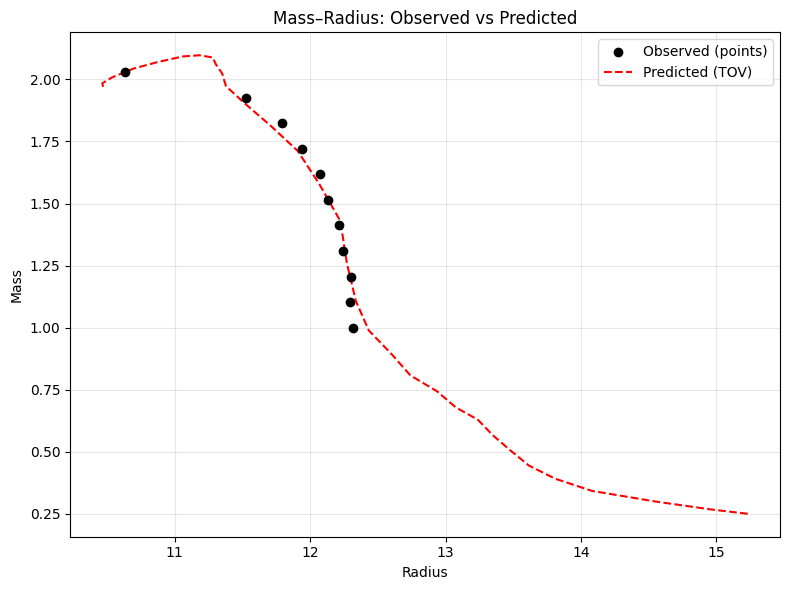

In [8]:
mr_relation_pred = tov(p_pred)

# Convert torch tensor → NumPy
mr_pred_flat = mr_relation_pred.detach().cpu().numpy().squeeze()

# Inverse-transform M and R separately
mass_pred = mr_pred_flat[:, 0] * M_MAX
radius_pred = mr_pred_flat[:, 1] * (R_MAX - R_MIN) + R_MIN

# Observed M–R (in physical units)
mass_obs = M_targets
radius_obs = R_obs

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(radius_obs, mass_obs, color="black", label="Observed (points)", zorder=3)
plt.plot(radius_pred, mass_pred, "--", color="red", label="Predicted (TOV)", zorder=2)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.title("Mass–Radius: Observed vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
mass_pred

array([0.25078439, 0.26846674, 0.29975282, 0.34310133, 0.39198164,
       0.44489646, 0.50741015, 0.56968512, 0.62952322, 0.67921598,
       0.74397712, 0.80790589, 0.89462129, 0.98912195, 1.10755311,
       1.26035005, 1.42888604, 1.57811967, 1.71196493, 1.81560656,
       1.90547369, 1.97294156, 2.02320139, 2.06063005, 2.08790092,
       2.09685685, 2.0920599 , 2.06935267, 2.04350142, 2.00697488,
       1.98368184, 1.9625003 ])

In [10]:
mass_obs

array([1.        , 1.10292139, 1.20584277, 1.30876416, 1.41168554,
       1.51460693, 1.61752832, 1.7204497 , 1.82337109, 1.92629247,
       2.02921386])

In [11]:
radius_pred

array([15.23106039, 14.95796241, 14.55506966, 14.07962323, 13.80967173,
       13.61565015, 13.47500684, 13.34311769, 13.23849595, 13.07502887,
       12.93704782, 12.74008279, 12.59952019, 12.43267354, 12.33730726,
       12.27059924, 12.22333268, 12.0675971 , 11.90765566, 11.70310031,
       11.5118048 , 11.3776412 , 11.35029052, 11.3032158 , 11.28046644,
       11.18171825, 11.05954443, 10.87282373, 10.6975429 , 10.53422917,
       10.46498829, 10.47405691])

In [12]:
radius_obs

array([12.31328868, 12.29518074, 12.29882223, 12.2432468 , 12.2099397 ,
       12.13170946, 12.07433047, 11.94208376, 11.79506338, 11.52493689,
       10.6303966 ])